- 소프트 맥스

In [1]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join('./data',os.listdir('data')[1]))
df

,1,2,3,4,5,6,7
0,10,23,29,33,37,40,16
1,9,13,21,25,32,42,2
2,11,16,19,21,27,31,30
3,14,27,30,31,40,42,2
4,16,24,29,40,41,42,3
...,...,...,...,...,...,...,...
1187,9,19,29,35,37,38,31
1188,7,9,19,23,26,45,33
1189,1,4,11,12,20,41,2
1190,10,16,23,36,39,40,11


In [2]:
before = []
result = []

for i in range(len(df)-450):
    before.append(df.iloc[0+i:450+i])
#    result.append(df.iloc[450+i])
     
    one_result = np.zeros(45)
    for j in df.iloc[450+i]:
        one_result[j-1] = 1
    result.append(one_result)

# 배치
before = np.array(before)
result = np.array(result)

# 스케일링
before = (before-1)/44
# result = (result-1)/44
before = before.reshape(-1,450,7,1)

In [3]:
before[0]

array([[[0.20454545],
        [0.5       ],
        [0.63636364],
        ...,
        [0.81818182],
        [0.88636364],
        [0.34090909]],

       [[0.18181818],
        [0.27272727],
        [0.45454545],
        ...,
        [0.70454545],
        [0.93181818],
        [0.02272727]],

       [[0.22727273],
        [0.34090909],
        [0.40909091],
        ...,
        [0.59090909],
        [0.68181818],
        [0.65909091]],

       ...,

       [[0.04545455],
        [0.13636364],
        [0.27272727],
        ...,
        [0.88636364],
        [0.90909091],
        [0.79545455]],

       [[0.04545455],
        [0.20454545],
        [0.43181818],
        ...,
        [0.77272727],
        [0.95454545],
        [0.79545455]],

       [[0.11363636],
        [0.29545455],
        [0.40909091],
        ...,
        [0.5       ],
        [0.68181818],
        [0.27272727]]])

In [4]:
result

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(before, result, test_size=0.2)

In [6]:
y_train.shape

(593, 45)

In [7]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", input_shape=x_train.shape[1:], activation='relu'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D(7))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Reshape(target_shape=(32,1)))
model.add(tf.keras.layers.LSTM(units = 45,
                               return_sequences = True,
                               input_shape = (32, 1),
                               activation = 'tanh'
))
model.add(tf.keras.layers.Reshape(target_shape=(32*45,)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(45, activation='sigmoid'))
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 450, 7, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 450, 7, 32)        102432    
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 1, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 1, 32)         128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64, 1, 32)         0         
                                                                 
 global_average_pooling2d (  (None, 32)              

In [8]:
# RMSE 정의
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

# model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[root_mean_squared_error])
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics=[root_mean_squared_error])

In [9]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
history = model.fit(x_train, y_train, batch_size=7, epochs=30, validation_split=0.2, callbacks=earlystop)
# history = model.fit(x_train, y_train, batch_size=7, epochs=30, validation_split=0.2)

Epoch 1/30


68/68 [==============================] - 17s 158ms/step - loss: 0.4947 - root_mean_squared_error: 0.3941 - val_loss: 0.4446 - val_root_mean_squared_error: 0.3679
Epoch 2/30
68/68 [==============================] - 8s 118ms/step - loss: 0.4346 - root_mean_squared_error: 0.3633 - val_loss: 0.4365 - val_root_mean_squared_error: 0.3642
Epoch 3/30
68/68 [==============================] - 10s 147ms/step - loss: 0.4344 - root_mean_squared_error: 0.3632 - val_loss: 0.4362 - val_root_mean_squared_error: 0.3641
Epoch 4/30
68/68 [==============================] - 7s 107ms/step - loss: 0.4338 - root_mean_squared_error: 0.3630 - val_loss: 0.4354 - val_root_mean_squared_error: 0.3637
Epoch 5/30
68/68 [==============================] - 6s 84ms/step - loss: 0.4338 - root_mean_squared_error: 0.3630 - val_loss: 0.4362 - val_root_mean_squared_error: 0.3639
Epoch 6/30
68/68 [==============================] - 5s 79ms/step - loss: 0.4332 - root_mean_squared_error: 0.3628 - val_loss: 0.4646 - va

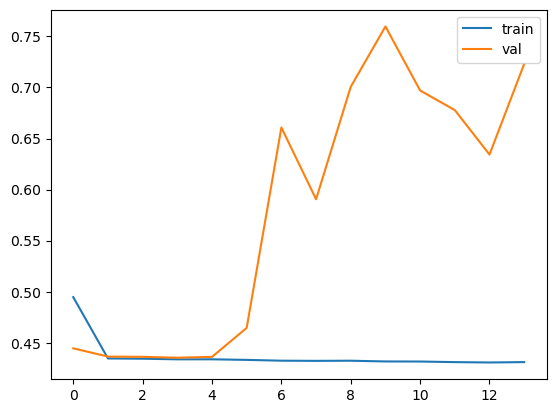

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [12]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 2s 106ms/step - loss: 0.4352 - root_mean_squared_error: 0.3638


[0.4352046847343445, 0.3638007342815399]

In [13]:
# 비교하고 싶은 순서
i = -1

In [14]:
y_real = pd.DataFrame(result[i])
y_real[y_real[0] == 1].index + 1

Index([6, 9, 16, 17, 19, 24, 28], dtype='int64')

In [15]:
y_pred = model.predict(np.array(before[i]).reshape(1,-1,7,1))

1/1 [==============================] - 1s 1s/step


In [16]:
pred = pd.Series(y_pred.reshape(-1))
pred

0     0.155051
1     0.175069
2     0.179627
3     0.169132
4     0.163170
5     0.209211
6     0.192351
7     0.169048
8     0.141110
9     0.189671
10    0.185358
11    0.232470
12    0.152289
13    0.182909
14    0.184278
15    0.198894
16    0.192655
17    0.178069
18    0.140261
19    0.205718
20    0.189837
21    0.184853
22    0.181635
23    0.165537
24    0.179060
25    0.188474
26    0.203425
27    0.195272
28    0.186833
29    0.184042
30    0.192494
31    0.170029
32    0.196130
33    0.230285
34    0.169526
35    0.173645
36    0.170920
37    0.223582
38    0.159350
39    0.165500
40    0.204102
41    0.178309
42    0.203098
43    0.188782
44    0.153556
dtype: float32

In [17]:
pred = pd.Series(y_pred.reshape(-1))
(pred.sort_values(ascending=False).index + 1)[:6].sort_values()

Index([6, 12, 20, 34, 38, 41], dtype='int64')

In [18]:
real_pred = model.predict(np.array(df[-450:]).reshape(1,-1,7,1))
real_pred = pd.Series(real_pred.reshape(-1))
(real_pred.sort_values(ascending=False).index + 1)[:6].sort_values()

1/1 [==============================] - 1s 1s/step


Index([8, 20, 23, 37, 43, 44], dtype='int64')

In [19]:
random_pred = real_pred + np.random.rand(45)/10
(random_pred.sort_values(ascending=False).index + 1)[:6].sort_values()

Index([20, 23, 26, 37, 43, 44], dtype='int64')

In [20]:
random_pred = real_pred + np.random.rand(45)/5
(random_pred.sort_values(ascending=False).index + 1)[:6].sort_values()

Index([4, 14, 20, 26, 40, 43], dtype='int64')

In [21]:
random_pred = real_pred + np.random.rand(45)
(random_pred.sort_values(ascending=False).index + 1)[:6].sort_values()

Index([5, 7, 25, 26, 37, 43], dtype='int64')

- 시그모이드

In [34]:
import pandas as pd
import numpy as np
import os

df = pd.read_csv(os.path.join('./data',os.listdir('data')[1]))
df

,1,2,3,4,5,6,7
0,10,23,29,33,37,40,16
1,9,13,21,25,32,42,2
2,11,16,19,21,27,31,30
3,14,27,30,31,40,42,2
4,16,24,29,40,41,42,3
...,...,...,...,...,...,...,...
1162,2,13,15,16,33,43,4
1163,17,18,23,25,38,39,22
1164,6,7,27,29,38,45,17
1165,14,23,25,27,29,42,16


In [35]:
before = []
result = []

for i in range(len(df)-450):
    before.append(df.iloc[0+i:450+i])
    result.append(df.iloc[450+i])

# 배치
before = np.array(before)
result = np.array(result)

# 스케일링
before = (before-1)/44
result = (result-1)/44
before = before.reshape(-1,450,7,1)

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(before, result, test_size=0.2)

In [37]:
y_train.shape

(573, 7)

In [38]:
import tensorflow as tf

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", input_shape=x_train.shape[1:], activation='relu'))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPool2D(7))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Reshape(target_shape=(32,1)))
model.add(tf.keras.layers.LSTM(units = 45,
                               return_sequences = False,
                               input_shape = (32, 1),
                               activation = 'tanh'
))
# model.add(tf.keras.layers.Reshape(target_shape=(32*45,)))
# model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(7, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 450, 7, 128)       1280      
                                                                 
 conv2d_3 (Conv2D)           (None, 450, 7, 32)        102432    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 1, 32)         0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 64, 1, 32)         128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 64, 1, 32)         0         
                                                                 
 global_average_pooling2d_1  (None, 32)               

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [40]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [41]:
history = model.fit(x_train, y_train, batch_size=7, epochs=30, validation_split=0.2, callbacks=earlystop)

Epoch 1/30
66/66 [==============================] - 13s 105ms/step - loss: 0.0457 - mean_absolute_error: 0.1704 - val_loss: 0.0326 - val_mean_absolute_error: 0.1415
Epoch 2/30
66/66 [==============================] - 6s 85ms/step - loss: 0.0311 - mean_absolute_error: 0.1380 - val_loss: 0.0325 - val_mean_absolute_error: 0.1427
Epoch 3/30
66/66 [==============================] - 5s 82ms/step - loss: 0.0313 - mean_absolute_error: 0.1386 - val_loss: 0.0330 - val_mean_absolute_error: 0.1426
Epoch 4/30
66/66 [==============================] - 5s 83ms/step - loss: 0.0314 - mean_absolute_error: 0.1387 - val_loss: 0.0325 - val_mean_absolute_error: 0.1430
Epoch 5/30
66/66 [==============================] - 5s 82ms/step - loss: 0.0312 - mean_absolute_error: 0.1381 - val_loss: 0.0326 - val_mean_absolute_error: 0.1420
Epoch 6/30
66/66 [==============================] - 5s 82ms/step - loss: 0.0314 - mean_absolute_error: 0.1387 - val_loss: 0.0325 - val_mean_absolute_error: 0.1423
Epoch 7/30
66/66 [==

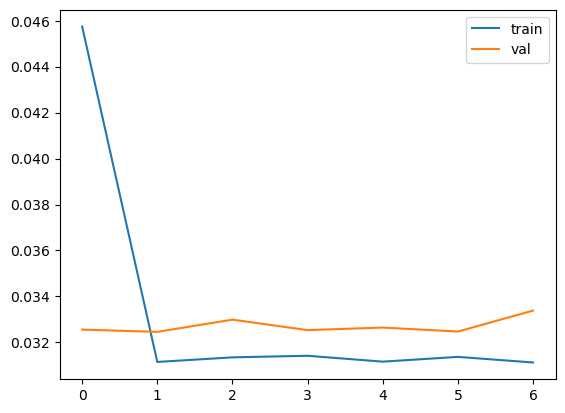

In [42]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [43]:
model.evaluate(x_test, y_test)

5/5 [==============================] - 0s 80ms/step - loss: 0.0316 - mean_absolute_error: 0.1435


[0.03162856772542, 0.14347580075263977]

In [44]:
# 비교하고 싶은 순서
i = -1

In [23]:
result[i]*44+1

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       45.,  1., 45.,  1.,  1., 45., 45.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., 45.,  1.,  1.,  1.,  1., 45., 45.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [24]:
pred = model.predict(before[i].reshape(1,-1,7,1))

1/1 [==============================] - 1s 712ms/step


In [25]:
(pred*44+1).astype(int)

array([[1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1,
        1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1,
        1]])

In [45]:
real_before = df[-450:]
real_pred = model.predict(((np.array(real_before)-1)/44).reshape(1,-1,7,1))

1/1 [==============================] - 1s 1s/step


In [46]:
real_pred*44+1

array([[ 7.306196, 14.140724, 21.386414, 26.4983  , 33.544006, 39.240566,
        22.24389 ]], dtype=float32)

In [47]:
(real_pred*44+1).astype(int)

array([[ 7, 14, 21, 26, 33, 39, 22]])

- LSTM + Sigmoid

In [235]:
import numpy as np
import os

df = np.loadtxt(os.path.join('./data',os.listdir('data')[1]), delimiter=",")
df = df[1:]
df

array([[10., 23., 29., ..., 37., 40., 16.],
       [ 9., 13., 21., ..., 32., 42.,  2.],
       [11., 16., 19., ..., 27., 31., 30.],
       ...,
       [ 6., 16., 34., ..., 39., 40., 11.],
       [ 1.,  3.,  4., ..., 42., 45., 36.],
       [ 6., 14., 30., ..., 40., 41., 29.]])

In [257]:
import numpy as np

batch = 450
encoder_input = [] # batch회 묶음 # x
decoder_input=[]  # y
decoder_target=[]  # y

for i in range(df.shape[0]-batch):
    x_batch = df[i:batch+i]
    y_batch = df[batch+i]
    y_batch = y_batch + 2 ## 시작, 종료 1, 2

    x_batch = x_batch.reshape(-1)
    x_batch = x_batch + 2 ## 시작, 종료 1, 2
    encoder_input.append(x_batch)
    decoder_input.append(np.insert(y_batch, 0, 1))
    decoder_target.append(np.append(y_batch, 2))

encoder_input = np.array(encoder_input)
decoder_input = np.array(decoder_input)
decoder_target = np.array(decoder_target)

In [258]:
encoder_input = encoder_input.astype(int)
decoder_input = decoder_input.astype(int)
decoder_target = decoder_target.astype(int)

In [259]:
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(657, 3150)
(657, 8)
(657, 8)


In [260]:
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 526
훈련 레이블의 개수 : 526
테스트 데이터의 개수 : 131
테스트 레이블의 개수 : 131


In [295]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 47
hidden_size = 8

# 인코더
encoder_inputs = Input(shape=(x_train.shape[-1],))

# 인코더의 임베딩 층
enc_emb = Embedding(45, embedding_dim)(encoder_inputs)

## 인코더의 LSTM 단층
# encoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout=0.2)
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [296]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(47, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [298]:
# 디코더의 출력층
decoder_softmax_layer = Dense(47, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 3150)]               0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 3150, 47)             2115      ['input_30[0][0]']            
                                                                                                  
 lstm_57 (LSTM)              [(None, 3150, 8),            1792      ['embedding_29[0][0]']        
                              (None, 8),                                                          
                              (None, 8)]                                                          
                                                                                           

In [308]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(47, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 3150)]               0         []                            
                                                                                                  
 embedding_29 (Embedding)    (None, 3150, 47)             2115      ['input_30[0][0]']            
                                                                                                  
 lstm_57 (LSTM)              [(None, 3150, 8),            1792      ['embedding_29[0][0]']        
                              (None, 8),                                                          
                              (None, 8)]                                                          
                                                                                           

In [301]:
encoder_input_train.shape

(526, 3150)

In [309]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=16, epochs=15)

Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node model_24/embedding_30/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "C:\Users\Kimmingee\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever

  File "C:\Users\Kimmingee\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "C:\Users\Kimmingee\anaconda3\Lib\asyncio\events.py", line 80, in _run

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code

  File "C:\Users\Kimmingee\AppData\Local\Temp\ipykernel_3216\120047783.py", line 3, in <module>

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1150, in train_step

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "C:\Users\Kimmingee\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py", line 272, in call

indices[3,6] = 47 is not in [0, 47)
	 [[{{node model_24/embedding_30/embedding_lookup}}]] [Op:__inference_train_function_161262]